Last updated: Arjun (27/02/25)

# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from imports import *
from sparam import read_s4p, read_s2p, load_smatrix_fromdatasheet, shape_smatrix_general, s_plotter, interpolate_smatrices
from sources import gen_VSD_50, read_TA_V, noise_generator, V_to_TA
from devices import chain4ports, chain2ports, correlator, ideal_switch_gen, ideal_rrc_gen, ideal_amp_gen, perturbed_rrc_gen, ideal_delayline_gen


%matplotlib inline

plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'legend.fontsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
})

# Preping the pipeline

## Inputs signals

#### Get Antenna Voltage input

In [2]:
#load inputs of TA and convert to V_nu (VSD)
T_nu, V_nu, apsera_freq = read_TA_V(file='residues.txt', R=50)
print('\nLoaded Antenna VSD from temperature file---------')

#checking the max, min and length of the frequency array
print('\nMin: ' + str(min(apsera_freq)) + '\nMax: ' +  str(max(apsera_freq)) + '\nLen: ' +  str(len(apsera_freq)))

#checking the frequency array resolution
freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))
print(f'Spectral Resolution: {round(freq_res)/1e6} MHz')


Loaded Antenna VSD from temperature file---------

Min: 2600000000.0
Max: 3900000000.0
Len: 251
Spectral Resolution: 5.179283 MHz


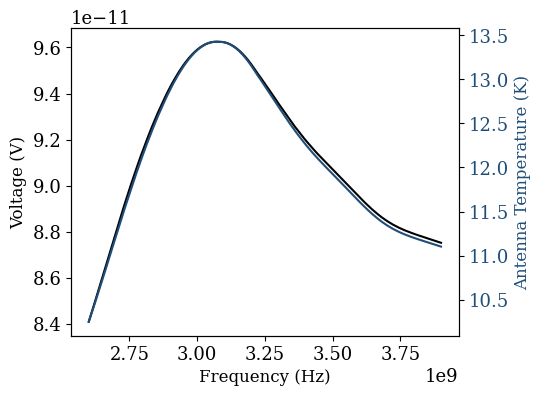

In [3]:
fig, ax1 = plt.subplots(figsize=(5, 4))  # Set figure size

# First plot (Voltage vs Frequency) - Black
ax1.plot(apsera_freq, V_nu, color='black', label='Voltage (V)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Voltage (V)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create second y-axis
ax2 = ax1.twinx()  
ax2.plot(apsera_freq, T_nu, color='#1f4e79', label='Antenna Temperature (K)')  # Dark blue
ax2.set_ylabel('Antenna Temperature (K)', color='#1f4e79')
ax2.tick_params(axis='y', labelcolor='#1f4e79')

# Show the plot

# Save as PDF
plt.savefig("photos/ant_volt_temp.pdf", format="pdf", dpi=300, bbox_inches="tight")

### Noise 300K VSD

In [4]:
#get noise at 300K
noise_300 = gen_VSD_50(300,freq_res,len(apsera_freq))

Generated VSD for 300K and Spectral Res 5179283 Hz @ 50 Ohms


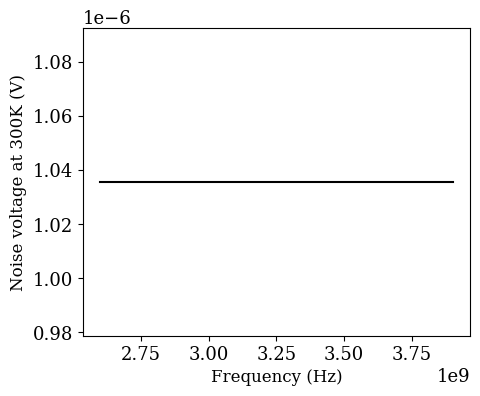

In [5]:
fig, ax1 = plt.subplots(figsize=(5, 4))  # Set figure size

ax1.plot(apsera_freq, noise_300, color='black', label='Voltage (V)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Noise voltage at 300K (V)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

plt.savefig("photos/noise_300k.pdf", format="pdf", dpi=300, bbox_inches="tight")

### Cold load 77K VSD

In [6]:
#get cold load at 77K
coldload_vsd = gen_VSD_50(77,freq_res,len(apsera_freq))

Generated VSD for 77K and Spectral Res 5179283 Hz @ 50 Ohms


### Hot load 315K VSD

In [7]:
#get noise at 50 ohms
freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))
hotload_vsd = gen_VSD_50(315,freq_res,len(apsera_freq))

Generated VSD for 315K and Spectral Res 5179283 Hz @ 50 Ohms


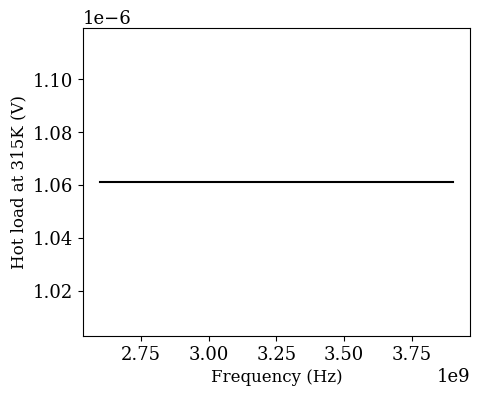

In [8]:
fig, ax1 = plt.subplots(figsize=(5, 4))  # Set figure size

ax1.plot(apsera_freq, hotload_vsd, color='black', label='Voltage (V)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Hot load at 315K (V)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

plt.savefig("photos/noise_300k.pdf", format="pdf", dpi=300, bbox_inches="tight")

## Devices

### RRC (NI, meas)

In [9]:
#load the rrc s4p file
freq_rrc, sparams_rrc = read_s4p('MS_SL_Transition_v32_taper_v2.s4p')


File format is MA, reading...
Converted frequency data to Hz frm GHz


### Switch (NI with web datasheet)

#### Datasheet

In [10]:
# Transfer switch data from manual
transferswitch_datasheet = '''1000.0 0.04 0.04 92.45 100.96 1.01 1.01 1.01 1.01 120.0
1500.0 0.05 0.05 98.61 87.38 1.01 1.01 1.01 1.01 120.0
2000.0 0.06 0.06 100.79 97.34 1.01 1.02 1.01 1.01 120.0
2500.0 0.07 0.06 97.51 104.72 1.03 1.03 1.03 1.02 120.0
3000.0 0.07 0.07 93.32 102.92 1.05 1.05 1.04 1.04 120.0
3500.0 0.08 0.08 98.46 99.72 1.06 1.07 1.05 1.05 120.0
4000.0 0.08 0.08 95.89 93.03 1.07 1.09 1.06 1.06 120.0
4500.0 0.09 0.09 92.30 99.42 1.07 1.09 1.07 1.07 120.0
5000.0 0.10 0.09 95.75 90.70 1.08 1.10 1.07 1.07 120.0'''

#### Switch On Loader

In [11]:
transferswitch_metadata_on = [[0], [5,1,4,9], [1,6,9,4], [4,9,6,2], [9,4,2,6]]

#load Transfer switch and interpolate to required length
[sparams_switch_on, _] = load_smatrix_fromdatasheet(ds=transferswitch_datasheet, meta=transferswitch_metadata_on, db_true=True, db_negate=True, req_length=1030, port=4, lim=[1e9,5e9])

make sure the input s params data is in dB!
s params input variable is string, reading...

datasheet frequency length: 9
datasheet sparams length: 16
Interpolation success...



#### Switch Off Loader

In [12]:
transferswitch_metadata_off = [[0], [7,3,2,9], [3,8,9,2], [2,9,8,3], [9,2,3,8]]

#load Transfer switch and interpolate to required length
[sparams_switch_off, _] = load_smatrix_fromdatasheet(ds=transferswitch_datasheet, meta=transferswitch_metadata_off, db_true=True, db_negate=True, req_length=1030, port=4, lim=[1e9,5e9])

make sure the input s params data is in dB!
s params input variable is string, reading...

datasheet frequency length: 9
datasheet sparams length: 16
Interpolation success...



### Amp 15dB (NI, web s2p)

In [13]:
# Load amplifier s matrix and interpolate it to apsera freq
freq_amp, sparams_amp = read_s2p('PHA-83W+_5.00V_Plus25DegC_TB-PHA-83WE+.s2p')
amp = shape_smatrix_general(sparams_amp, freq_amp, apsera_freq)
print('\nLoaded Amplifier S matrix and interpolated---------')

File format accepted, reading...
Frequency data in Hz
Frequency and S-matrix created

Loaded Amplifier S matrix and interpolated---------


### Device s-matrix check for APSERa

In [14]:
rrc, switch_on, switch_off = interpolate_smatrices(devices=[sparams_rrc, sparams_switch_on, sparams_switch_off], current_f_list=[freq_rrc]*3, new_f=apsera_freq)

All S matrices are compatible with each other and current freq


### Load ideal RRC, switch and amp and pert RRC

In [15]:
### IDEAL CASE
switch_ideal_on = ideal_switch_gen(apsera_freq, True)
switch_ideal_off = ideal_switch_gen(apsera_freq, False)

rrc_ideal = ideal_rrc_gen(apsera_freq)

amp_chain_gain = 10**(15/20) # linear units
amp_ideal_15 = ideal_amp_gen(apsera_freq, amp_chain_gain)
amp_chain_ant = 10**(40/20) # linear units
amp_ideal_40 = ideal_amp_gen(apsera_freq, amp_chain_ant)

# PERT RRC Gen
rrc_pert = perturbed_rrc_gen(apsera_freq, [0,5,-1,0], [0,5,-1,0])




S-Matrix of Ideal Switch On:

0j | 0j | (1+0j) | 0j
0j | 0j | 0j | (1+0j)
(1+0j) | 0j | 0j | 0j
0j | (1+0j) | 0j | 0j


S-Matrix of Ideal Switch Off:

0j | (1+0j) | 0j | 0j
(1+0j) | 0j | 0j | 0j
0j | 0j | 0j | (1+0j)
0j | 0j | (1+0j) | 0j


S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(4.329126434985893e-17-0.707j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(4.329126434985893e-17-0.707j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.329126434985893e-17+0.707j) | (4.329126434985893e-17-0.707j) | 0j


S-Matrix of Ideal Amplifier:

0 | (5.623413251903491+0j)
(5.623413251903491+0j) | 0


S-Matrix of Ideal Amplifier:

0 | (100+0j)
(100+0j) | 0


S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(0.21660637291740392-2.475822171557356j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(-0.027893324961079737-1.5980075167745655j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.32912643498589

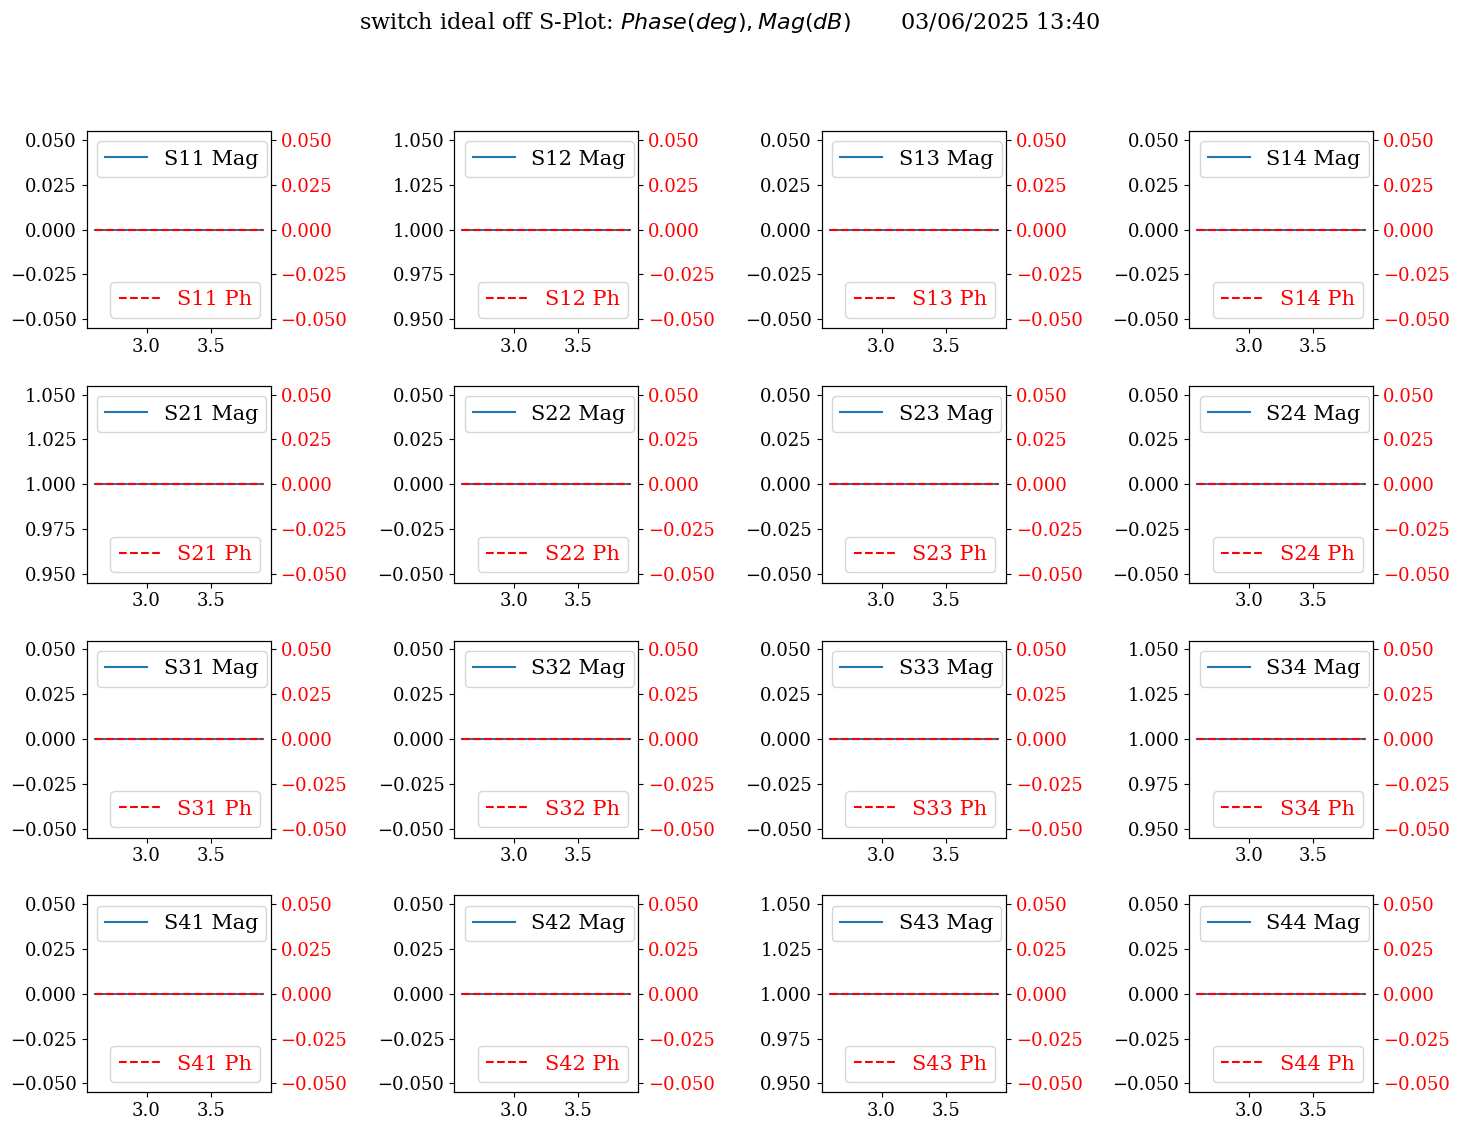

In [16]:
fig1 = s_plotter('switch ideal off', 'all', False, apsera_freq, 'GHz', switch_ideal_off, 4, None)

fig1.savefig("photos/rrc_ideal_off_splot.pdf", format="pdf", dpi=300, bbox_inches="tight")


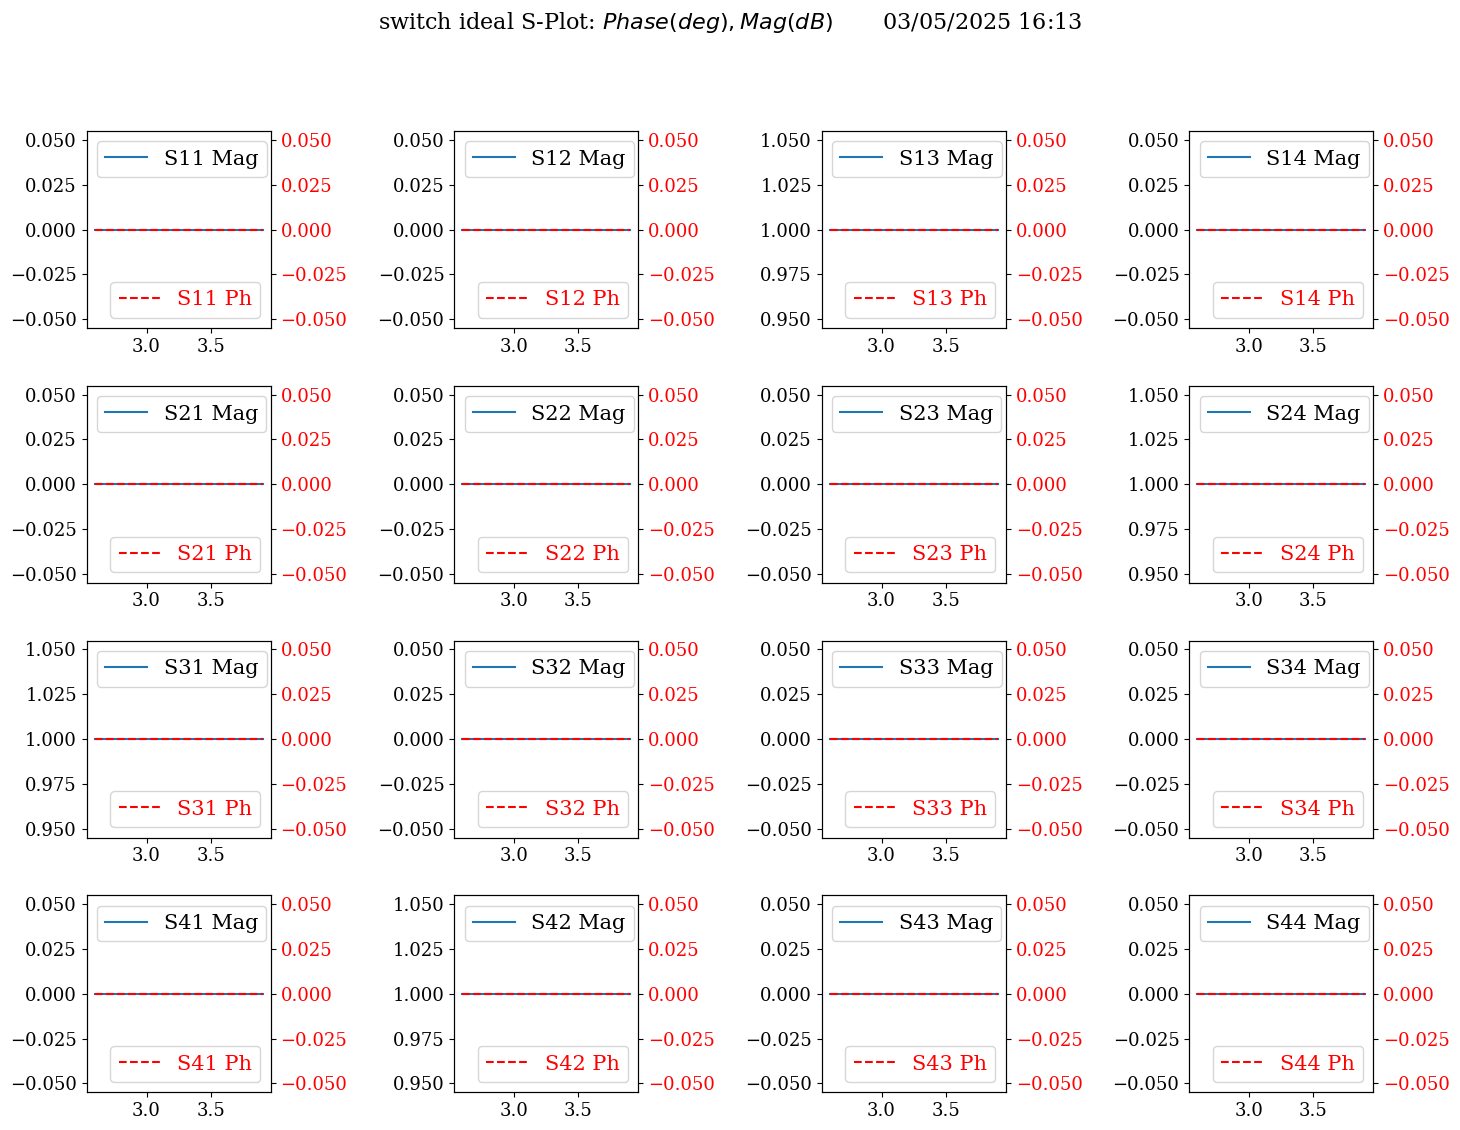

In [ ]:
fig1 = s_plotter('switch ideal', 'all', False, apsera_freq, 'GHz', switch_ideal_on, 4, None)

fig1.savefig("photos/rrc_ideal_on_splot.pdf", format="pdf", dpi=300, bbox_inches="tight")



S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(1.1199507978211693e-16-1.8290184543019632j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(1.0452360430722659e-16-1.7069999999999999j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.329126434985893e-17+0.707j) | (4.329126434985893e-17-0.707j) | 0j


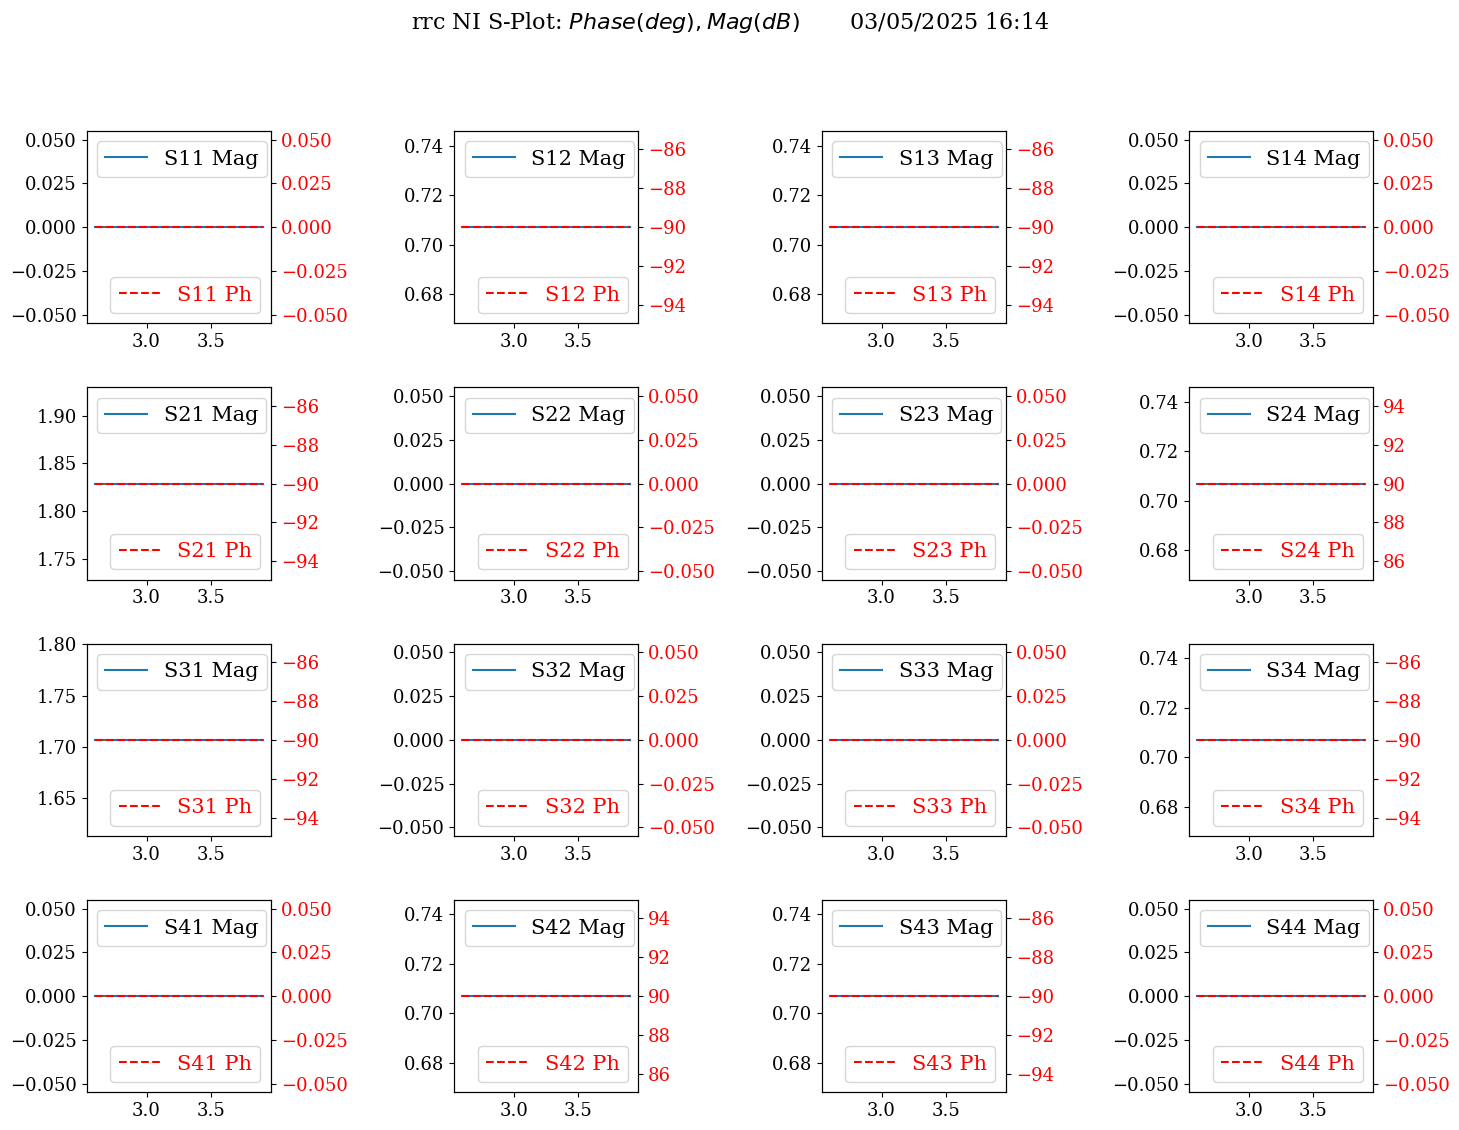

In [20]:
pert_rrc_gen_draw = perturbed_rrc_gen(apsera_freq, [0,1,0,0], [0,0,0,0])

fig1 = s_plotter('rrc NI', 'all', False, apsera_freq, 'GHz', pert_rrc_gen_draw, 4, None)

#fig1.savefig("photos/rrc_ideal_splot.pdf", format="pdf", dpi=300, bbox_inches="tight")

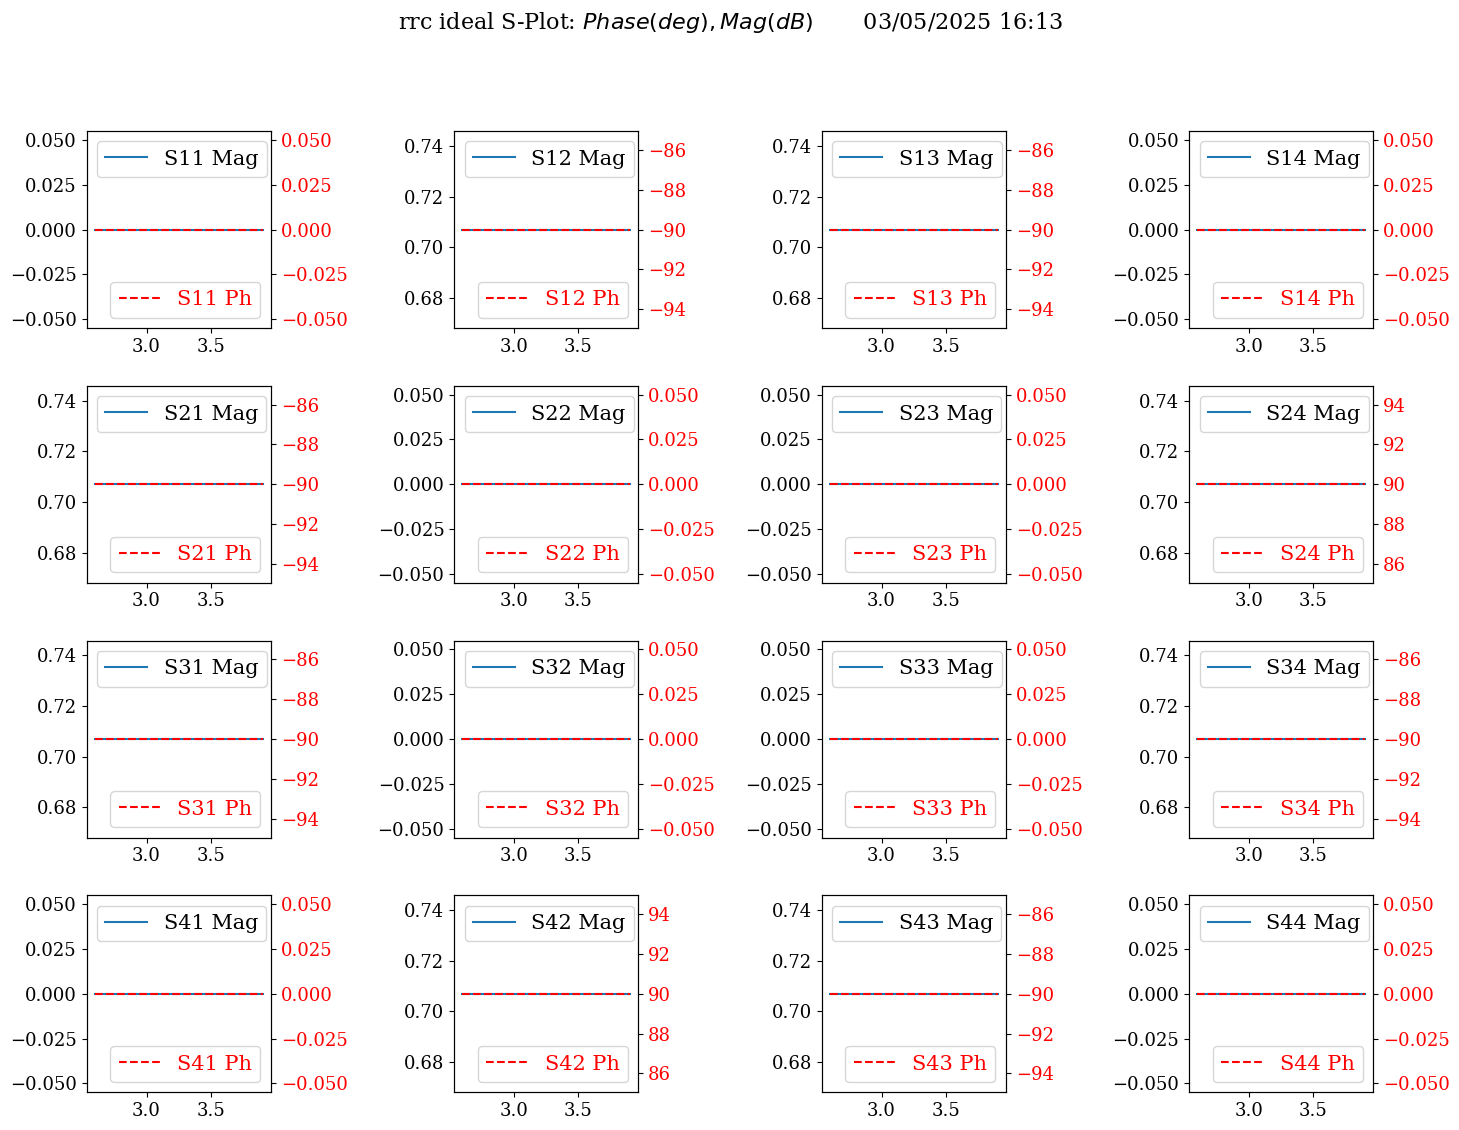

In [18]:
fig1 = s_plotter('rrc ideal', 'all', False, apsera_freq, 'GHz', rrc_ideal, 4, None)

fig1.savefig("photos/rrc_ideal_splot.pdf", format="pdf", dpi=300, bbox_inches="tight")


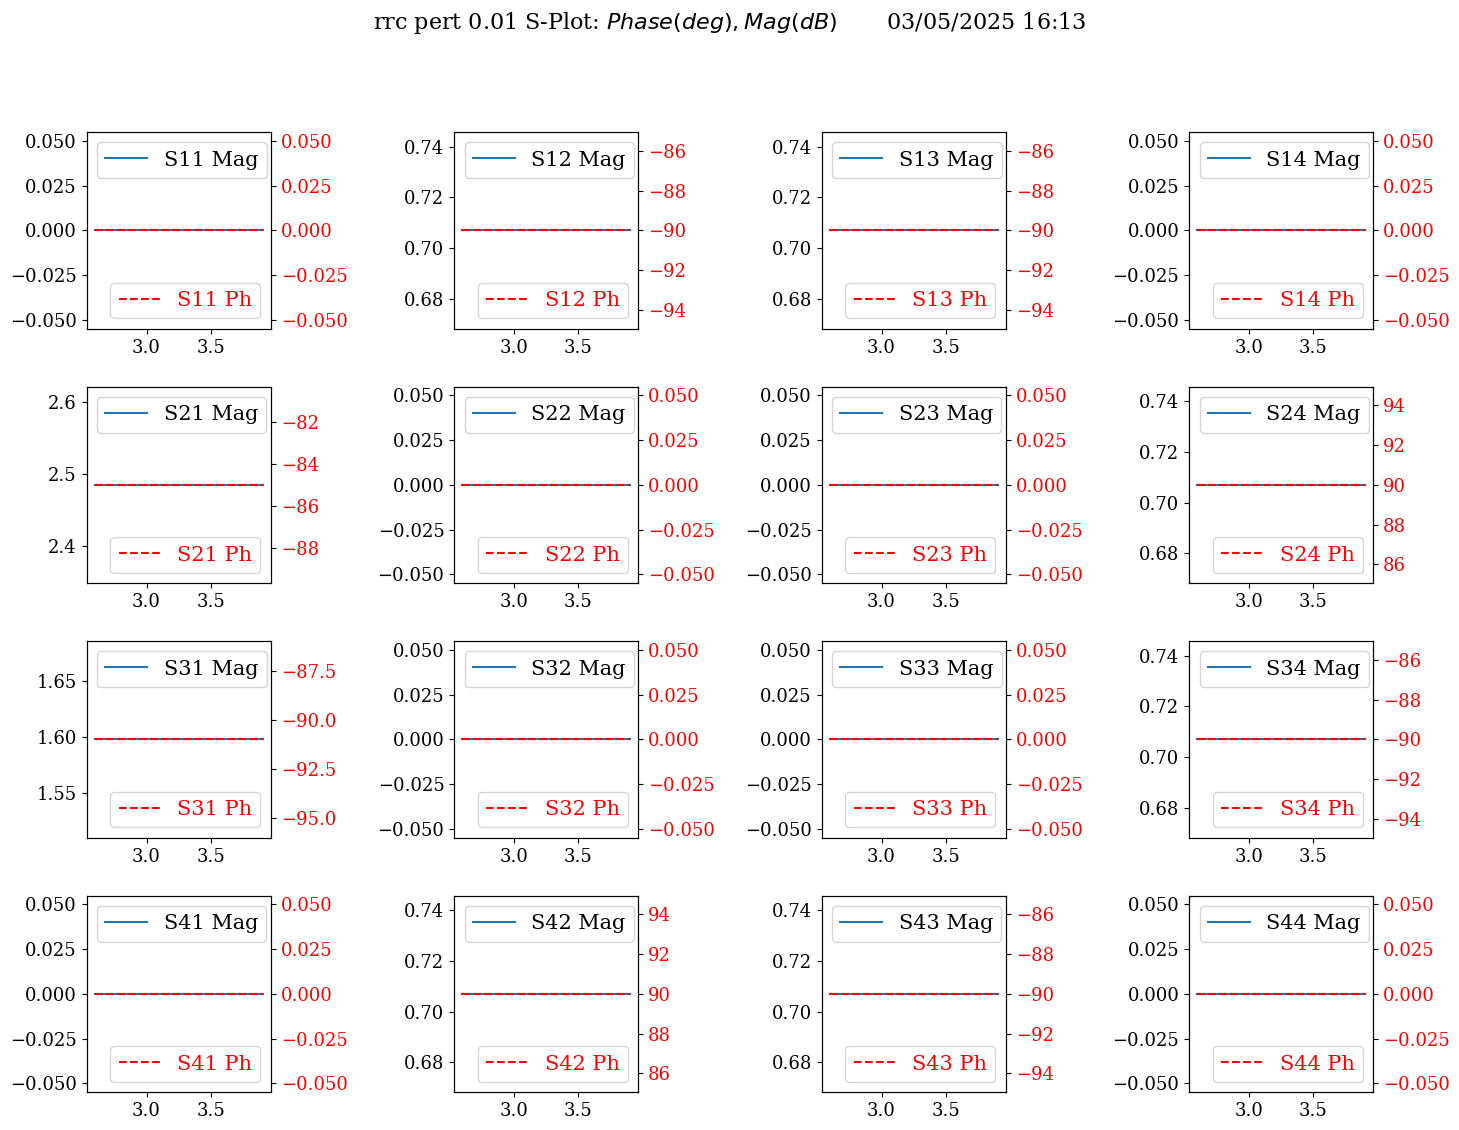

In [19]:
_ = s_plotter('rrc pert 0.01', 'all', False, apsera_freq, 'GHz', rrc_pert, 4, None)

# Feed the pipeline

#### Amplify antenna signal

In [17]:
delayline_30cm = ideal_delayline_gen(apsera_freq, 0.3)

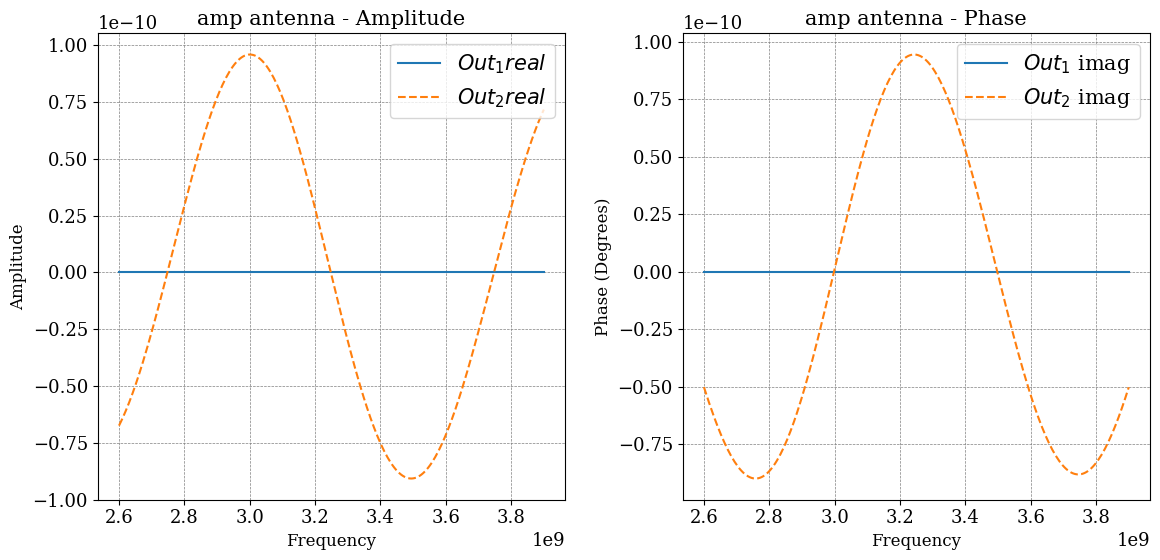

In [18]:
V_nu_amp_DL = chain2ports(
    title='amp antenna', 
    devices_sparam_list=[delayline_30cm], 
    input=[V_nu, [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=True)

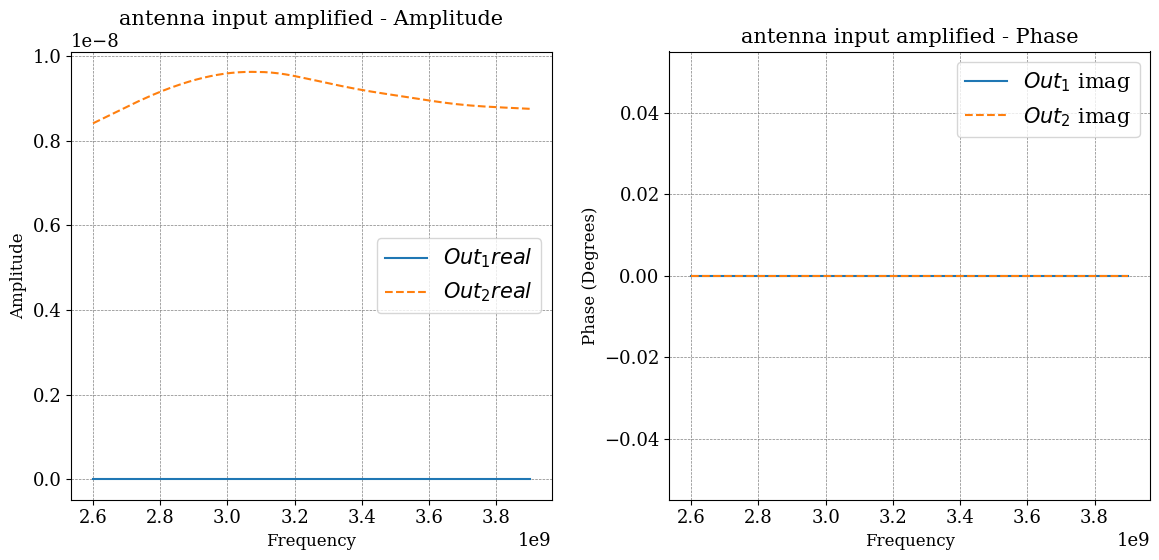

In [19]:
V_nu_amp = chain2ports(
    title='antenna input amplified', 
    devices_sparam_list=[amp_ideal_40], 
    input=[V_nu, [0]*len(apsera_freq)], 
    freq_=apsera_freq,
        plot=True)

#### Add noise to amp signal

C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


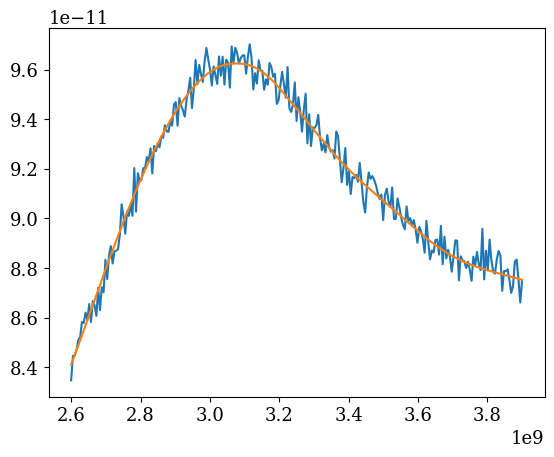

In [20]:
# Add noise to the signal
noise = noise_generator(SNR_dB = 45, V = V_nu)
noisy_V_nu_amp = V_nu + noise

plt.plot(apsera_freq, noisy_V_nu_amp)
plt.plot(apsera_freq, V_nu)

# Ideal T_ext extraction with RPA

## Get Tobs ideal

### $T_{A}$, 300K ---> On, Ideal 

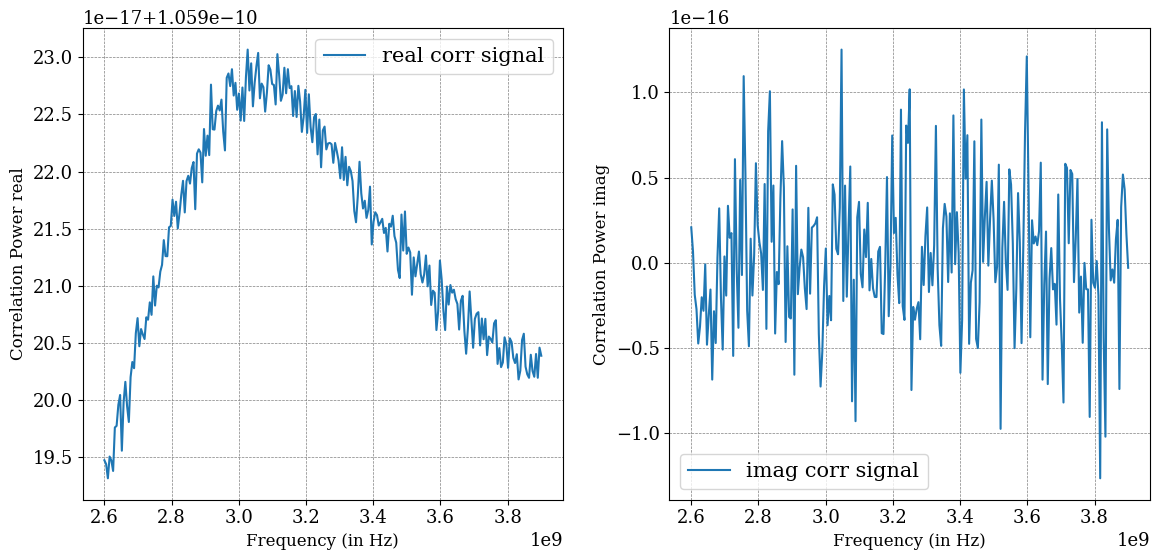

In [24]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
b_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_on, pert_rrc_gen_draw],     
    input=[noisy_V_nu_amp, [0]*len(apsera_freq), [0]*len(apsera_freq), noise_300.astype(np.complex128)],  
    freq_=apsera_freq,
    plot=False   )

b2_top_ideal_on = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False   )

b2_bottom_ideal_on = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False )

#correlate the output
t_obs01 = correlator(input1=b2_top_ideal_on[1], input2=b2_bottom_ideal_on[1], x=apsera_freq, plot=True)  #t_obs01

### $T_{A}$, 300K ---> Off, Ideal 

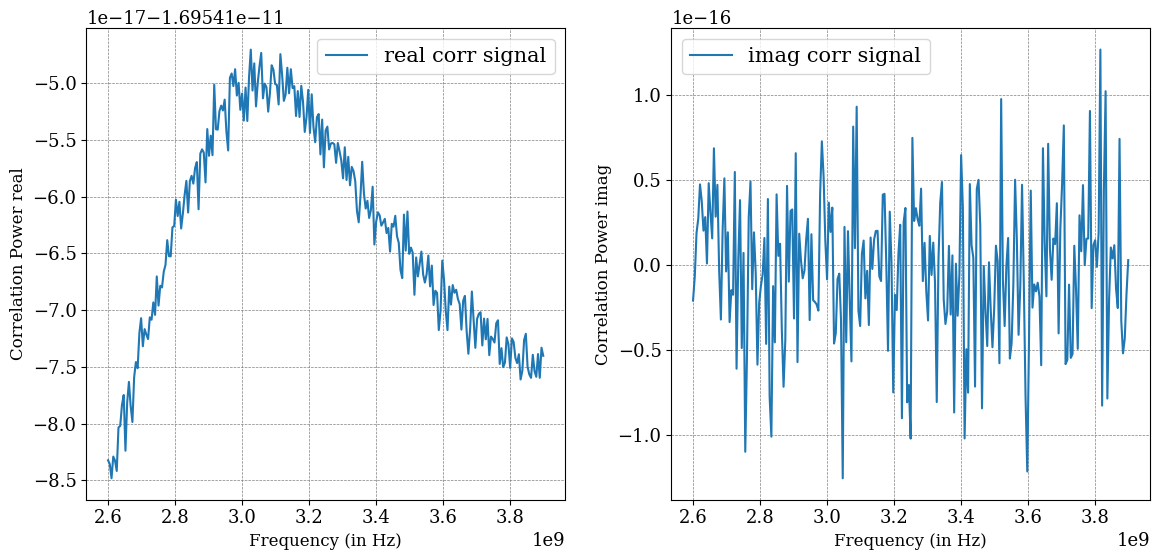

In [25]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
b_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_off, pert_rrc_gen_draw], 
    input=[noisy_V_nu_amp, [0]*len(apsera_freq), [0]*len(apsera_freq), noise_300],  
    freq_=apsera_freq,
    plot=False   )

b2_top_ideal_off = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False   )

b2_bottom_ideal_off = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False   )

#correlate the output
t_obs00 = correlator(input1=b2_top_ideal_off[1], input2=b2_bottom_ideal_off[1], x=apsera_freq, plot=True)  #t_obs00

### Get Tobs ideal

1.228543779794756e-10


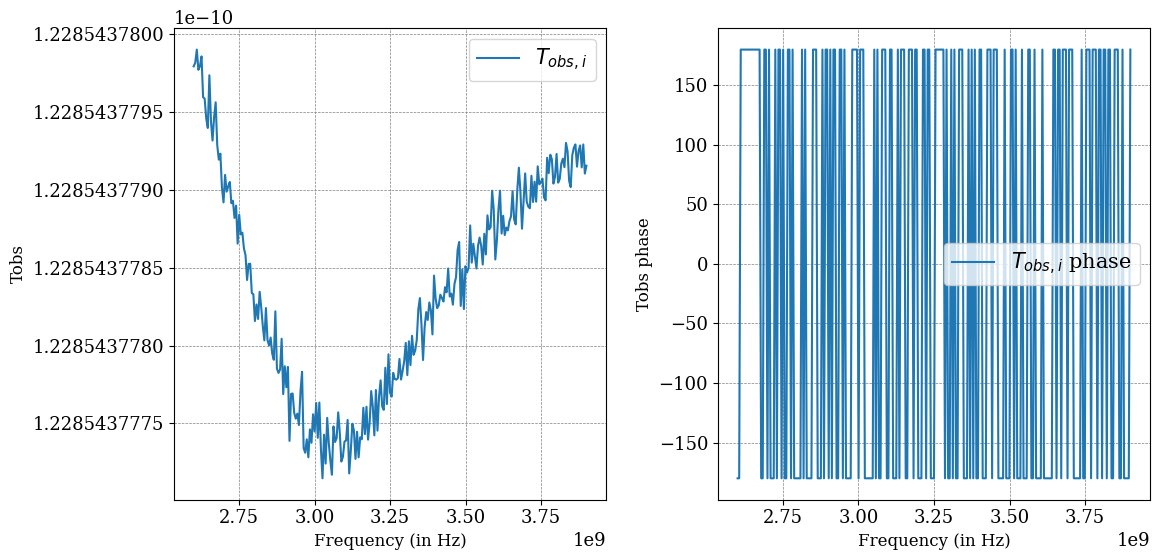

In [26]:
Tobs_ideal = t_obs00 - t_obs01   #  through (on) - crossed (off)
# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
print( np.abs(Tobs_ideal)[0])
# First plot: Correlation amplitude
axs[0].plot(apsera_freq, np.abs(Tobs_ideal), label='$T_{obs,i}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useOffset=False)

axs[0].grid()
axs[0].legend()

# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.angle(Tobs_ideal, deg=True), label='$T_{obs,i}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
#axs[1].set_ylim(-1,1)
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

## Get Tcold ideal

### 77K, 300K ---> On, non Ideal

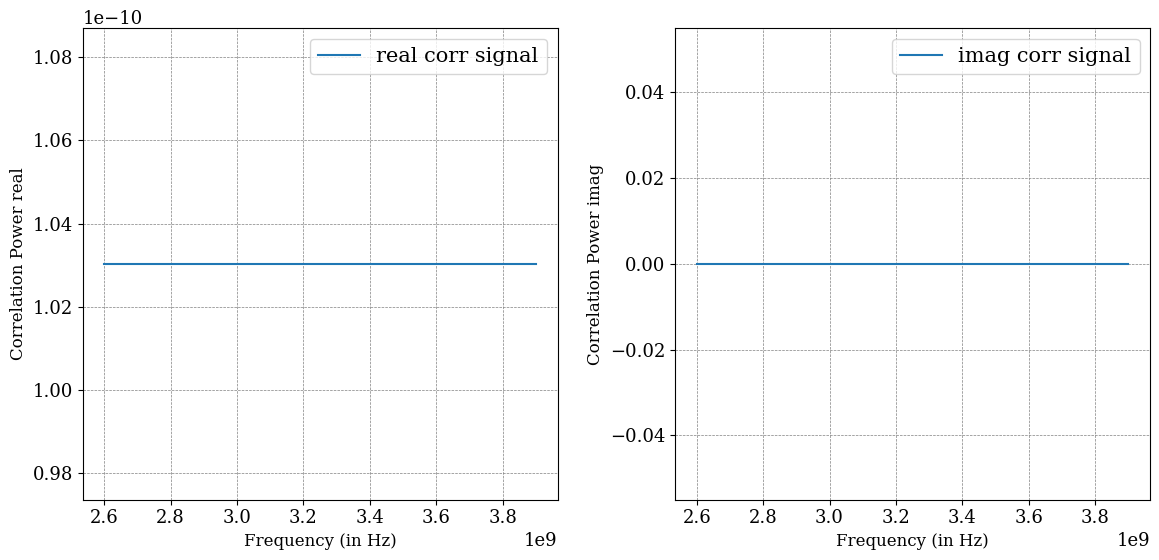

In [27]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
b_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_on, pert_rrc_gen_draw], 
    input=[coldload_vsd, [0]*len(apsera_freq), [0]*len(apsera_freq), noise_300],  
    freq_=apsera_freq,
    plot=False     )

b2_top_ideal_on = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False   )

b2_bottom_ideal_on = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False  )

#correlate the output
t_cold01 = correlator(input1=b2_top_ideal_on[1], input2=b2_bottom_ideal_on[1], x=apsera_freq, plot=True)  #t_obs01

### 77K, 300K ---> Switch off, non Ideal case

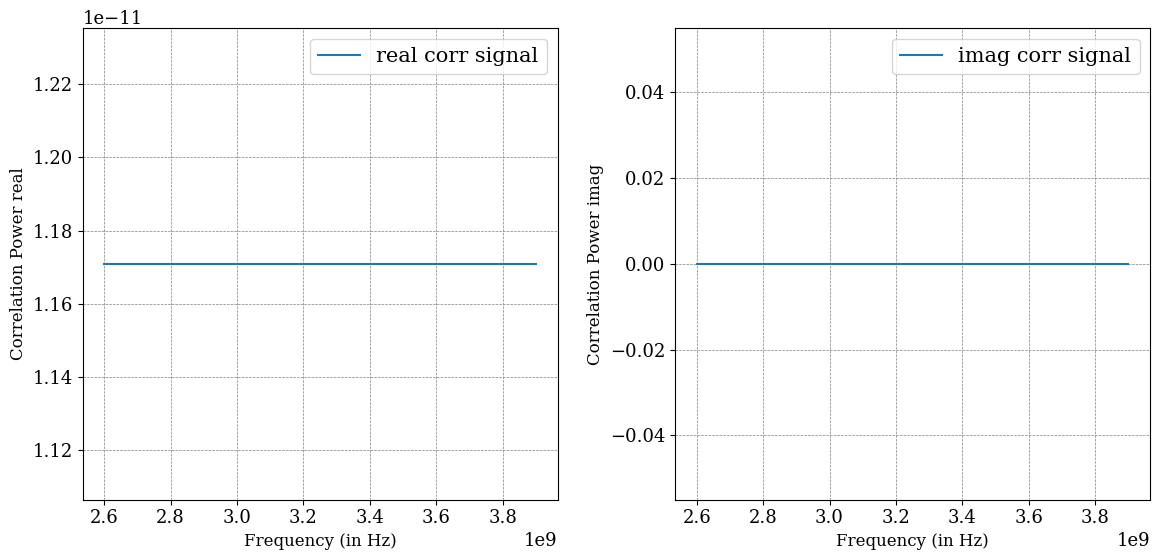

In [29]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
b_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_off, pert_rrc_gen_draw], 
    input=[coldload_vsd, [0]*len(apsera_freq), [0]*len(apsera_freq), noise_300],  
    freq_=apsera_freq,
    plot=False   )

b2_top_ideal_off = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False     )

b2_bottom_ideal_off = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False    )

#correlate the output
t_cold00 = correlator(input1=b2_top_ideal_off[1], input2=b2_bottom_ideal_off[1], x=apsera_freq, plot=True)  #t_obs00

### Get Tcold ideal

C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


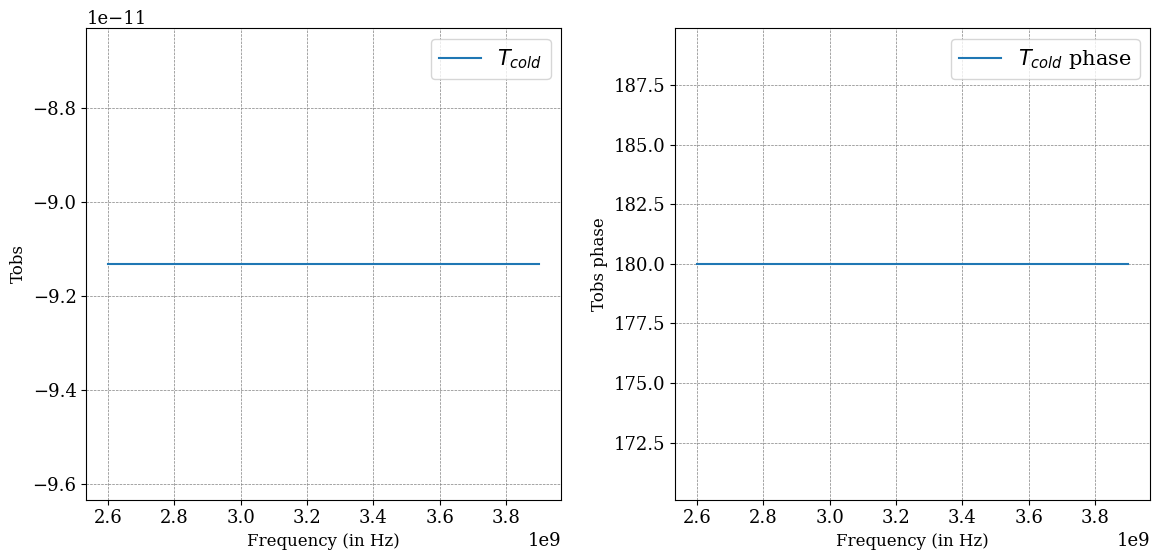

In [30]:
Tcold = t_cold00 - t_cold01

# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0].plot(apsera_freq, (Tcold), label='$T_{cold}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].grid()
axs[0].legend()


# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.angle(Tcold, deg=True), label='$T_{cold}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

## Get Thot ideal

### 315K, 300K ---> Switch on, non Ideal case

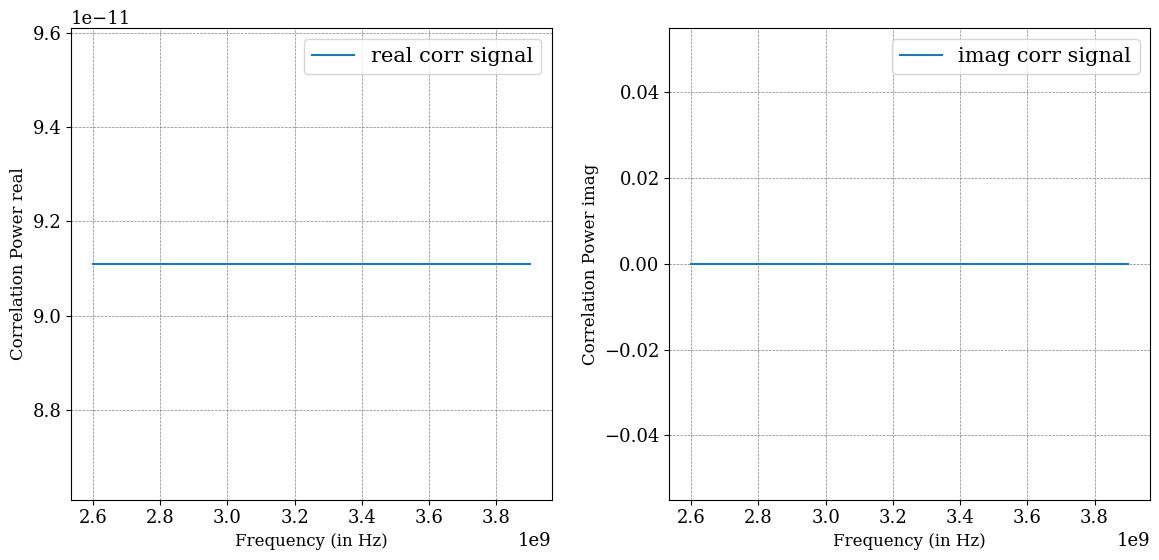

In [31]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
b_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_on, pert_rrc_gen_draw], 
    input=[hotload_vsd, [0]*len(apsera_freq), [0]*len(apsera_freq), noise_300],  
    freq_=apsera_freq,
    plot=False     )

b2_top_ideal_on = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False  )

b2_bottom_ideal_on = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False    )

#correlate the output
t_hot01 = correlator(input1=b2_top_ideal_on[1], input2=b2_bottom_ideal_on[1], x=apsera_freq, plot=True)  #t_obs01

### 315K, 300K ---> Switch off, non Ideal case

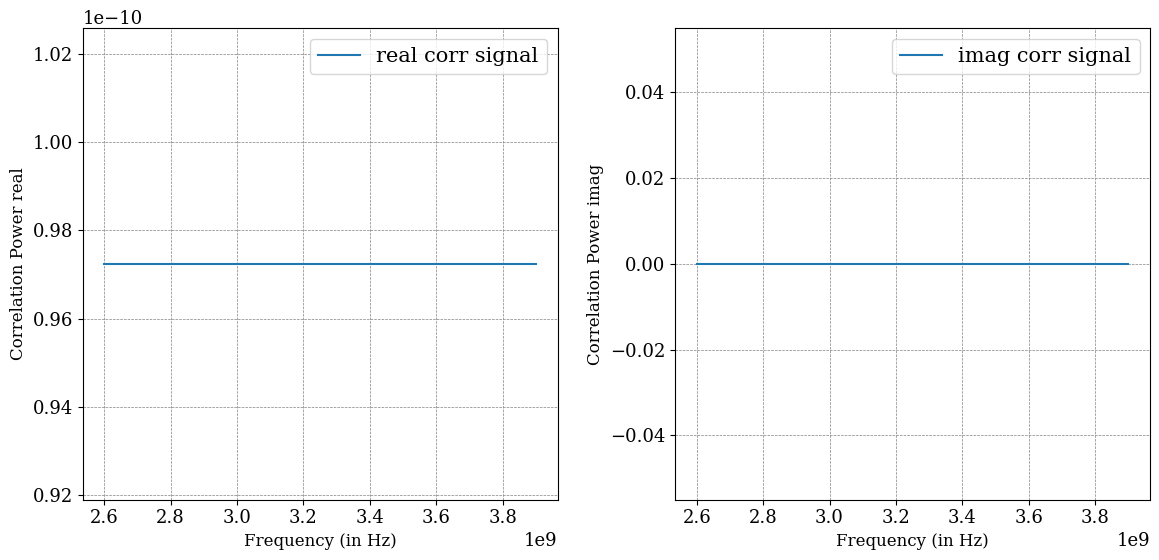

In [32]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
b_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_off, pert_rrc_gen_draw], 
    input=[hotload_vsd, [0]*len(apsera_freq), [0]*len(apsera_freq), noise_300],  
    freq_=apsera_freq,
    plot=False     )

b2_top_ideal_off = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False    )

b2_bottom_ideal_off = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
    freq_=apsera_freq,
    plot=False   )

#correlate the output
t_hot00 = correlator(input1=b2_top_ideal_off[1], input2=b2_bottom_ideal_off[1], x=apsera_freq, plot=True)  #t_obs00

### Get Thot ideal

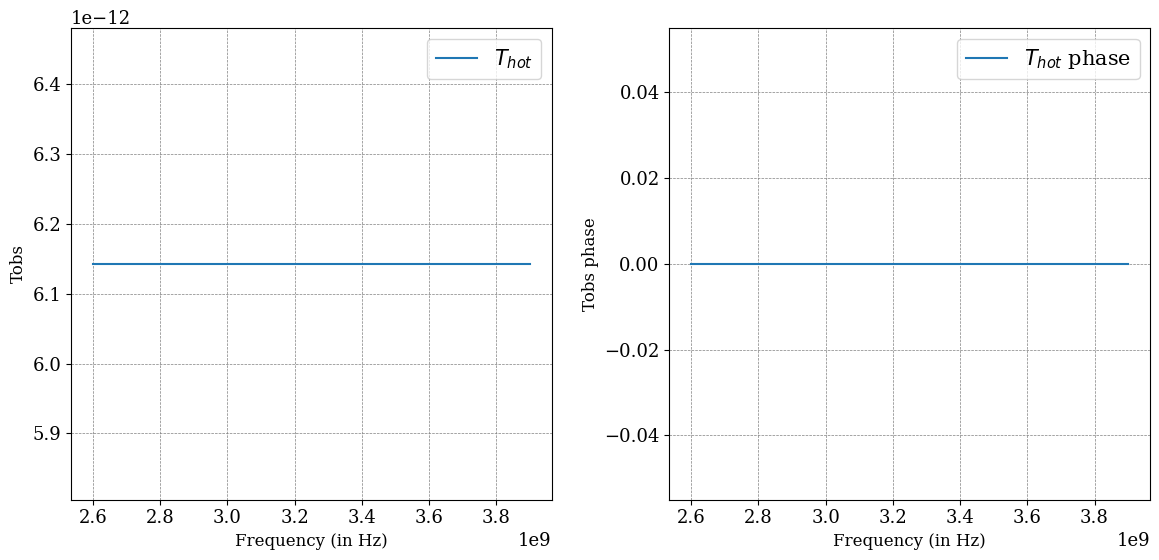

In [33]:
Thot = t_hot00 - t_hot01

# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0].plot(apsera_freq, (Thot), label='$T_{hot}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].grid()
axs[0].legend()

# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.degrees(np.angle(Thot)), label='$T_{hot}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

## Get Text ideal

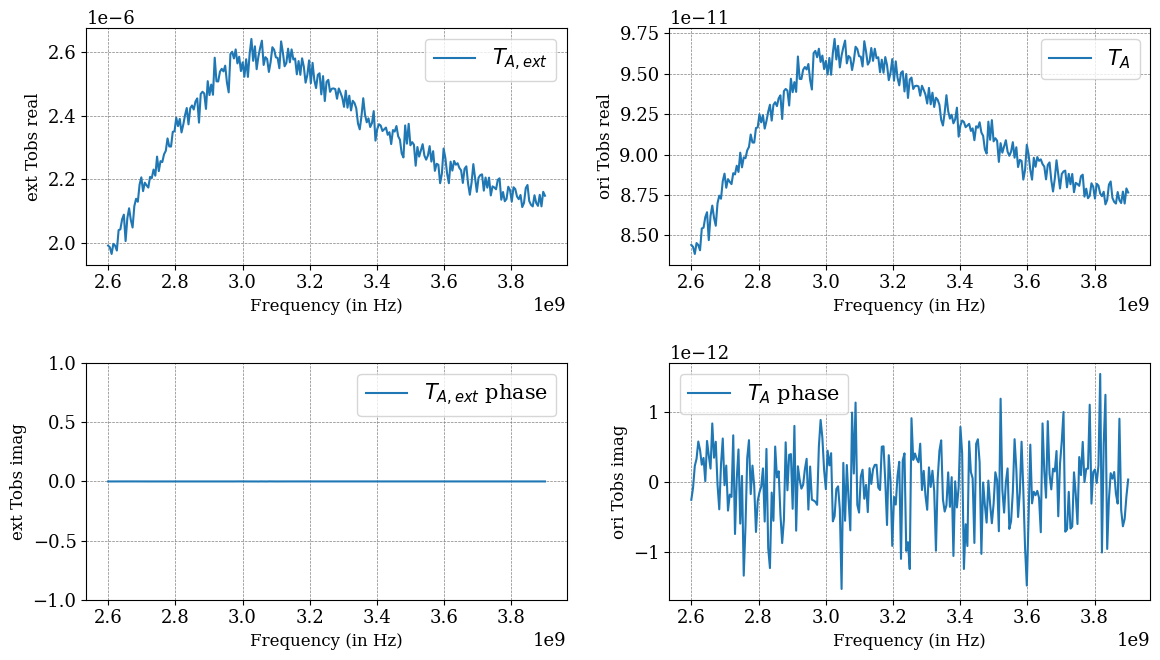

In [35]:
T_a_reflected = ((Tobs_ideal - Tcold) * (315-77))/(Thot-Tcold) + 77

# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# First plot: Correlation amplitude
axs[0][0].plot(apsera_freq, np.real(T_a_reflected), label='$T_{A,ext}$')
#axs[0].plot(apsera_freq, np.abs(V_nu_amp), label='$T_{A}$')
axs[0][0].set_ylabel('ext Tobs real')
axs[0][0].set_xlabel('Frequency (in Hz)')
axs[0][0].grid()
axs[0][0].legend()
axs[0][0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useOffset=False)
axs[0][0].ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))

# second plot: Correlation amplitude
axs[0][1].plot(apsera_freq, np.real(noisy_V_nu_amp), label='$T_{A}$')
axs[0][1].set_ylabel('ori Tobs real')
axs[0][1].set_xlabel('Frequency (in Hz)')
axs[0][1].grid()
axs[0][1].legend()

# Third plot: Correlation phase
axs[1][0].plot(apsera_freq, np.imag(T_a_reflected), label='$T_{A,ext}$ phase')
axs[1][0].set_ylabel('ext Tobs imag')
axs[1][0].set_xlabel('Frequency (in Hz)')
axs[1][0].grid()
axs[1][0].set_ylim(-1,1)
axs[1][0].legend()

# Fourth plot: Correlation phase
axs[1][1].plot(apsera_freq, np.imag(noisy_V_nu_amp), label='$T_{A}$ phase')
axs[1][1].set_ylabel('ori Tobs imag')
axs[1][1].set_xlabel('Frequency (in Hz)')
axs[1][1].grid()
axs[1][1].legend()
plt.tight_layout()


# Pipeline

In [19]:
def rf_chain_simulate(switch_on_, switch_off_, rrc_, amp_, input): 
    
    # ANTENNA TEMP
    #  crossed (on) ---> 01
    b_rrc_ideal = chain4ports(
        title='switch+rrc', 
        devices_sparam_list=[switch_on_, rrc_], 
        input=[input[0], [0]*len(apsera_freq), [0]*len(apsera_freq), input[1]],  
        freq_=apsera_freq,
        plot=False )

    b2_top_ideal_on = chain2ports(
        title='amp top', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False  )

    b2_bottom_ideal_on = chain2ports(
        title='amp bottom', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    #correlate the output
    t_obs01 = correlator(input1=b2_top_ideal_on[1], input2=b2_bottom_ideal_on[1], x=apsera_freq, plot=False)  #t_obs01

    #  through (off)  ---> 00
    b_rrc_ideal = chain4ports(
        title='switch+rrc', 
        devices_sparam_list=[switch_off_, rrc_], 
        input=[input[0], [0]*len(apsera_freq), [0]*len(apsera_freq), input[1]],  
        freq_=apsera_freq,
        plot=False       )

    b2_top_ideal_off = chain2ports(
        title='amp top', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    b2_bottom_ideal_off = chain2ports(
        title='amp bottom', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    #correlate the output
    t_obs00 = correlator(input1=b2_top_ideal_off[1], input2=b2_bottom_ideal_off[1], x=apsera_freq, plot=False)  #t_obs00

    Tobs_ = t_obs00 - t_obs01   # crossed (on) - through (off)
    

    #COLD LOAD
    #crossed (on) ---> 01
    b_rrc_ideal = chain4ports(
        title='switch+rrc', 
        devices_sparam_list=[switch_on_, rrc_], 
        input=[input[2], [0]*len(apsera_freq), [0]*len(apsera_freq), input[1]],  
        freq_=apsera_freq,
        plot=False )

    b2_top_ideal_on = chain2ports(
        title='amp top', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False  )

    b2_bottom_ideal_on = chain2ports(
        title='amp bottom', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    #correlate the output
    t_cold01 = correlator(input1=b2_top_ideal_on[1], input2=b2_bottom_ideal_on[1], x=apsera_freq, plot=False)  #t_obs01

    #  through (off)  ---> 00
    b_rrc_ideal = chain4ports(
        title='ideal switch+rrc', 
        devices_sparam_list=[switch_off_, rrc_], 
        input=[input[2], [0]*len(apsera_freq), [0]*len(apsera_freq), input[1]],  
        freq_=apsera_freq,
        plot=False       )

    b2_top_ideal_off = chain2ports(
        title='ideal amp top', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    b2_bottom_ideal_off = chain2ports(
        title='ideal amp bottom', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    #correlate the output
    t_cold00 = correlator(input1=b2_top_ideal_off[1], input2=b2_bottom_ideal_off[1], x=apsera_freq, plot=False)  #t_obs00

    Tcold_ = t_cold00 - t_cold01   # crossed (on) - through (off)

    #HOT LOAD
    #crossed (on) ---> 01
    b_rrc_ideal = chain4ports(
        title='switch+rrc', 
        devices_sparam_list=[switch_on_, rrc_], 
        input=[input[3], [0]*len(apsera_freq), [0]*len(apsera_freq), input[1]],  
        freq_=apsera_freq,
        plot=False )

    b2_top_ideal_on = chain2ports(
        title='amp top', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False  )

    b2_bottom_ideal_on = chain2ports(
        title='amp bottom', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    #correlate the output
    t_hot01 = correlator(input1=b2_top_ideal_on[1], input2=b2_bottom_ideal_on[1], x=apsera_freq, plot=False)  #t_obs01

    #  through (off)  ---> 00
    b_rrc_ideal = chain4ports(
        title='ideal switch+rrc', 
        devices_sparam_list=[switch_off_, rrc_], 
        input=[input[3], [0]*len(apsera_freq), [0]*len(apsera_freq), input[1]],  
        freq_=apsera_freq,
        plot=False       )

    b2_top_ideal_off = chain2ports(
        title='ideal amp top', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[1], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    b2_bottom_ideal_off = chain2ports(
        title='ideal amp bottom', 
        devices_sparam_list=[amp_], 
        input=[b_rrc_ideal[2], [0]*len(apsera_freq)], 
        freq_=apsera_freq,
        plot=False   )

    #correlate the output
    t_hot00 = correlator(input1=b2_top_ideal_off[1], input2=b2_bottom_ideal_off[1], x=apsera_freq, plot=False)  #t_obs00

    Thot_ = t_hot00 - t_hot01   # crossed (on) - through (off)
    return Tobs_, Tcold_, Thot_

In [20]:
def apsera_pipeline(_input_, apsera_freq, switch_on, switch_off, rrc, amp):
    input_, Tcold_vsd, Thot_vsd, noise_300_ = _input_
    
    # two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
    ### ANTENNA TEMPERATURE
    Tobs_, Tcold_, Thot_ = rf_chain_simulate(switch_on, switch_off, rrc, amp, [input_, noise_300_, Tcold_vsd, Thot_vsd])
    
    # Extract antenna temperature    
    T_a_reflected = ((Tobs_ - Tcold_) * (315-77))/(Thot_-Tcold_) + 77
    
    #T_a_reflected = V_to_TA(V_a_reflected, freq_res_)

    # Create a 1x2 grid for two subplots side by side
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))

    # First plot: Correlation amplitude
    axs[0][0].plot(apsera_freq, np.real(T_a_reflected), label='$T_{A,ext}$')
    #axs[0].plot(apsera_freq, np.abs(V_nu_amp), label='$T_{A}$')
    axs[0][0].set_ylabel('ext Tobs real')
    axs[0][0].set_xlabel('Frequency (in Hz)')
    axs[0][0].grid()
    axs[0][0].legend()
    axs[0][0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useOffset=False)
    axs[0][0].ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))

    # second plot: Correlation amplitude
    axs[0][1].plot(apsera_freq, np.real(input_), label='$T_{A}$')
    axs[0][1].set_ylabel('ori Tobs real')
    axs[0][1].set_xlabel('Frequency (in Hz)')
    axs[0][1].grid()
    axs[0][1].legend()

    # Third plot: Correlation phase
    axs[1][0].plot(apsera_freq, np.imag(T_a_reflected), label='$T_{A,ext}$')
    axs[1][0].set_ylabel('ext Tobs imag')
    axs[1][0].set_xlabel('Frequency (in Hz)')
    axs[1][0].grid()
    axs[1][0].set_ylim(-1,1)
    axs[1][0].legend()

    # Fourth plot: Correlation phase
    axs[1][1].plot(apsera_freq, np.imag(input_), label='$T_{A}$')
    axs[1][1].set_ylabel('ori Tobs imag')
    axs[1][1].set_xlabel('Frequency (in Hz)')
    axs[1][1].grid()
    axs[1][1].legend()
    plt.tight_layout()
    return fig, T_a_reflected, Tobs_

## Run

C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


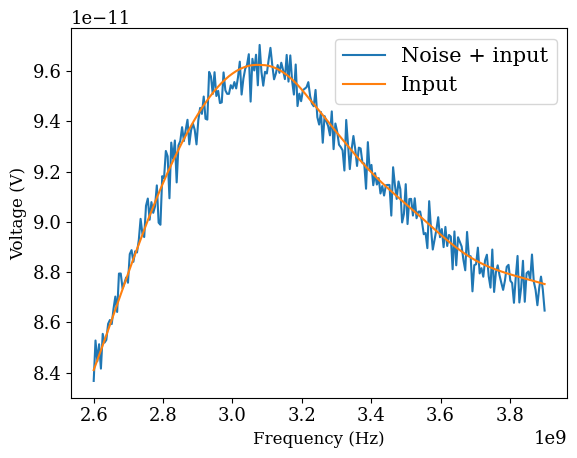

In [38]:
# Add noise to the signal
noise = noise_generator(SNR_dB=45, V=V_nu)
noisy_V_nu_amp = V_nu + noise

plt.plot(apsera_freq, noisy_V_nu_amp, label="Noise + input")
plt.plot(apsera_freq, V_nu, label="Input")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Voltage (V)', color='black')
plt.tick_params(axis='y', labelcolor='black')

plt.legend()
plt.show()

In [54]:
10**(np.array(6000)/20)

1e+300



S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(0.0002979277018029519-1.7069999740009032j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(1.0452360430722659e-16-1.7069999999999999j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.329126434985893e-17+0.707j) | (4.329126434985893e-17-0.707j) | 0j


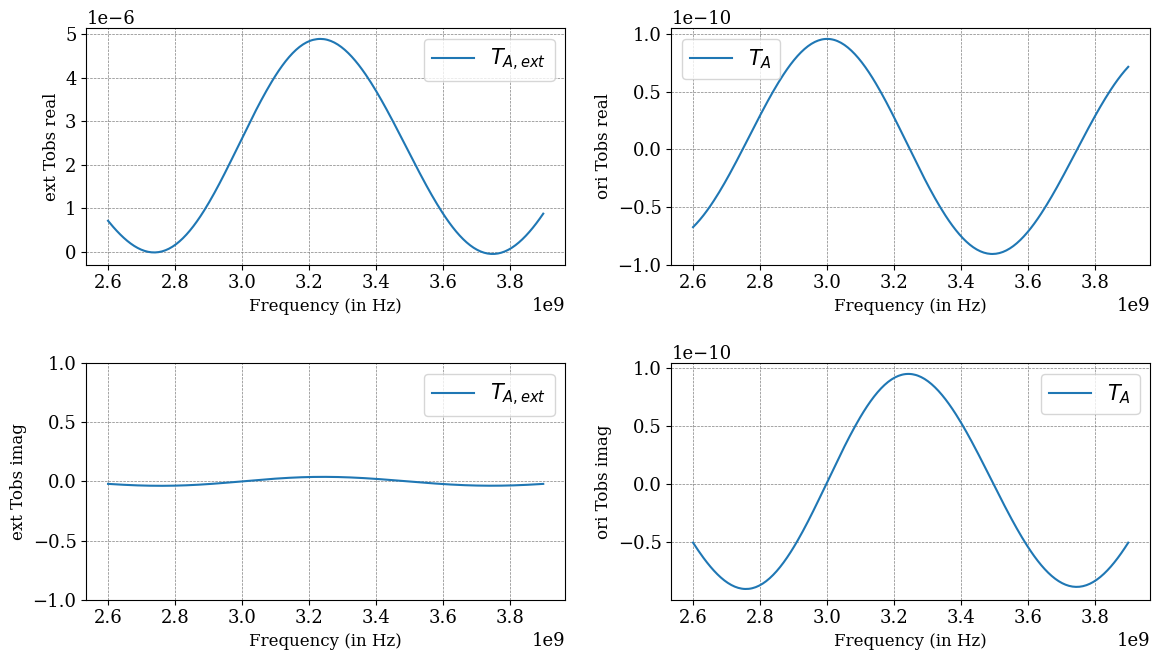

In [45]:
pert_rrc_gen_i = perturbed_rrc_gen(apsera_freq, [0,0,0,0], [0,0.01,0,0])

_, t_a, _ = apsera_pipeline([V_nu_amp_DL[1], coldload_vsd, hotload_vsd, noise_300], apsera_freq, switch_ideal_on, switch_ideal_off, pert_rrc_gen_i, amp_ideal_15)



S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(1.0452360430722659e-16-1.7069999999999999j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(1.0452360430722659e-16-1.7069999999999999j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.329126434985893e-17+0.707j) | (4.329126434985893e-17-0.707j) | 0j


S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(1.052326413869895e-16-1.7185794542598987j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(1.0382268350780046e-16-1.6955530946569388j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.329126434985893e-17+0.707j) | (4.329126434985893e-17-0.707j) | 0j


S-Matrix of Ideal RRC:

0j | (4.329126434985893e-17-0.707j) | (4.329126434985893e-17-0.707j) | 0j
(1.0594988872918606e-16-1.730292992280754j) | 0j | 0j | (4.329126434985893e-17+0.707j)
(1.0312978608241835e-16-1.6842372209558105j) | 0j | 0j | (4.329126434985893e-17-0.707j)
0j | (4.329126434985893e-1

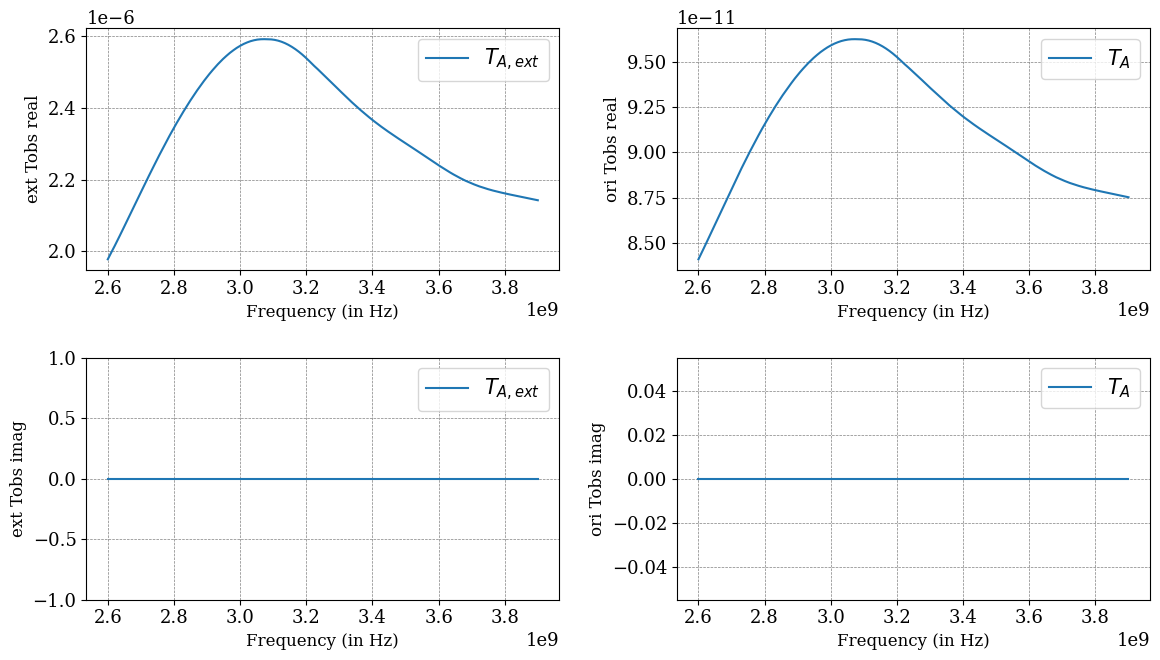

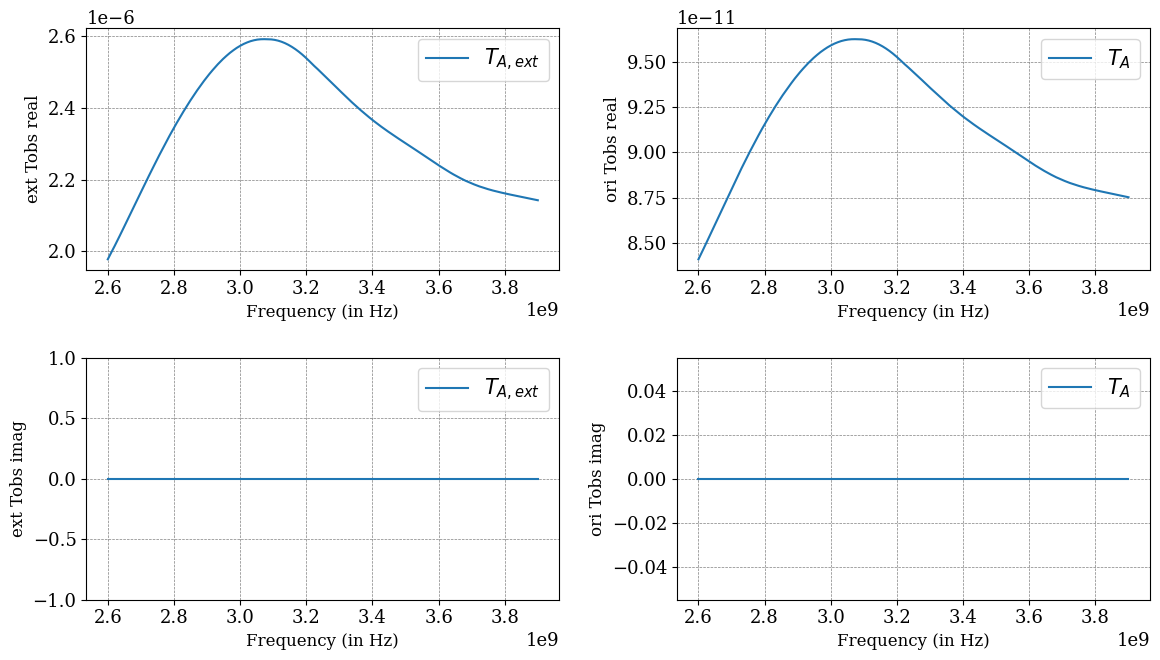

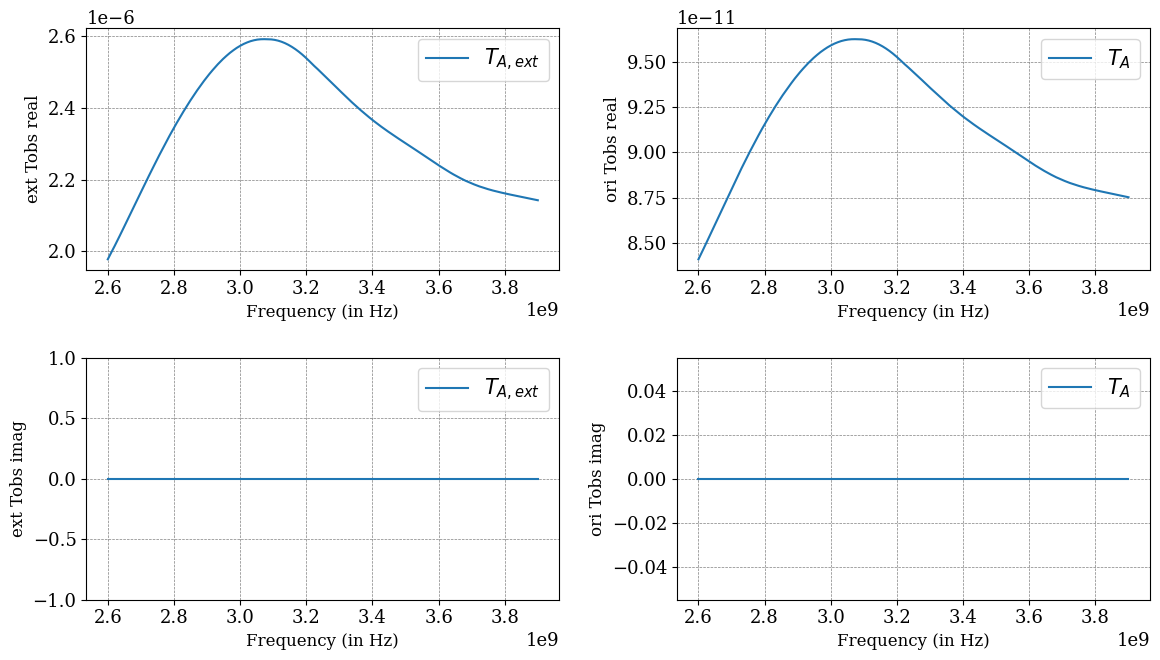

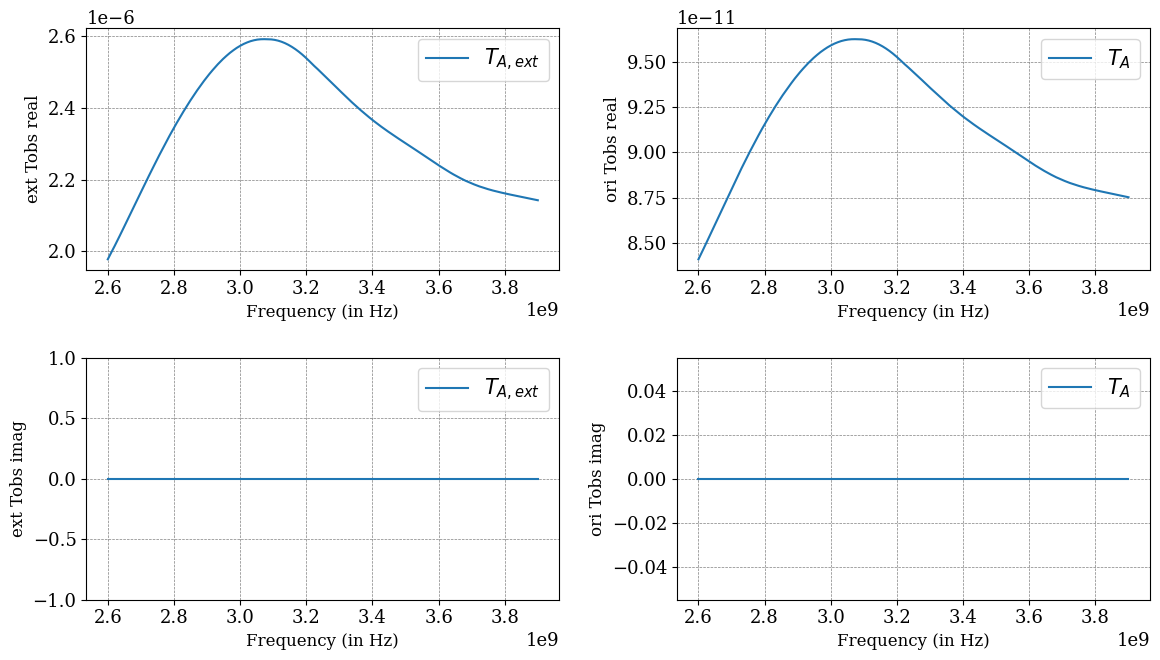

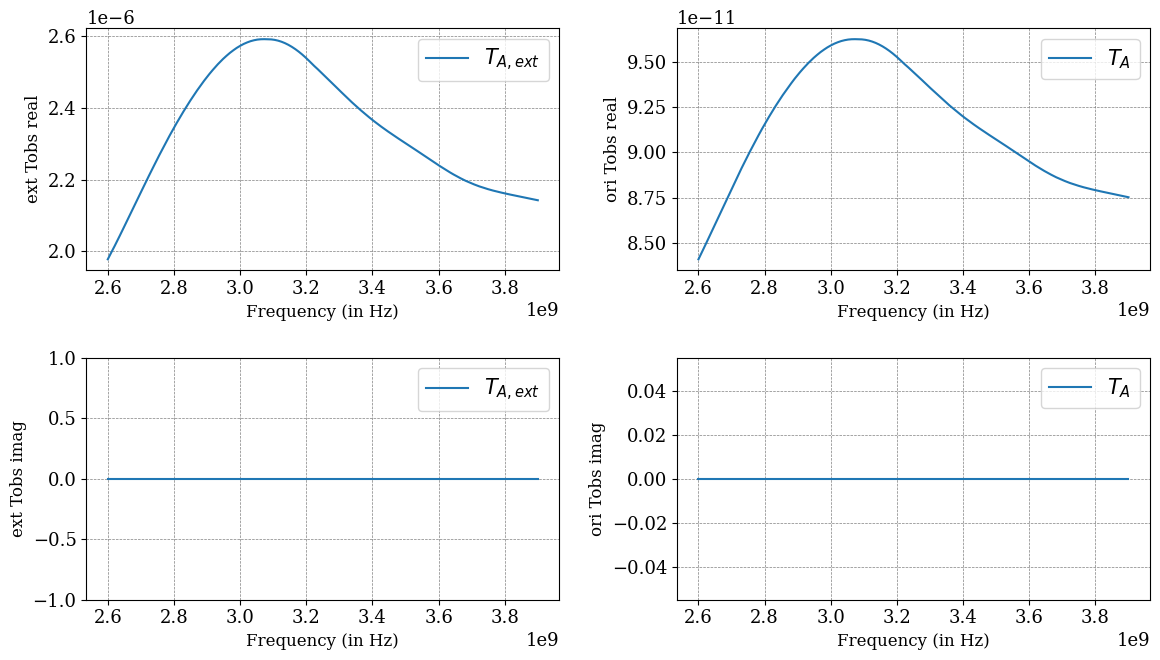

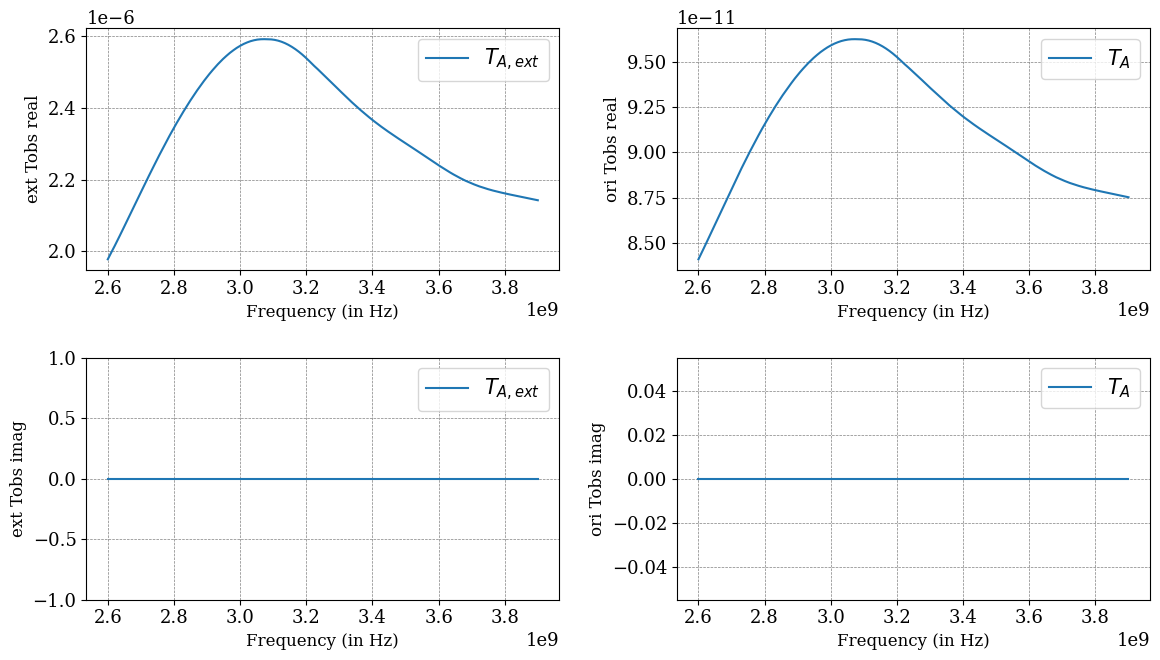

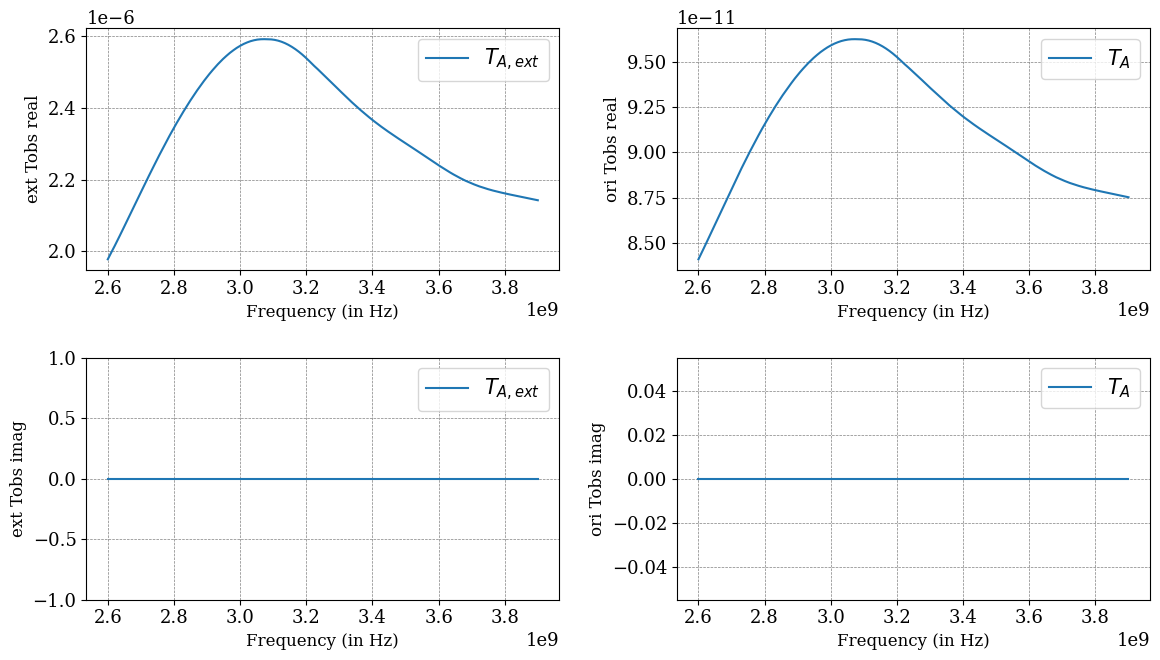

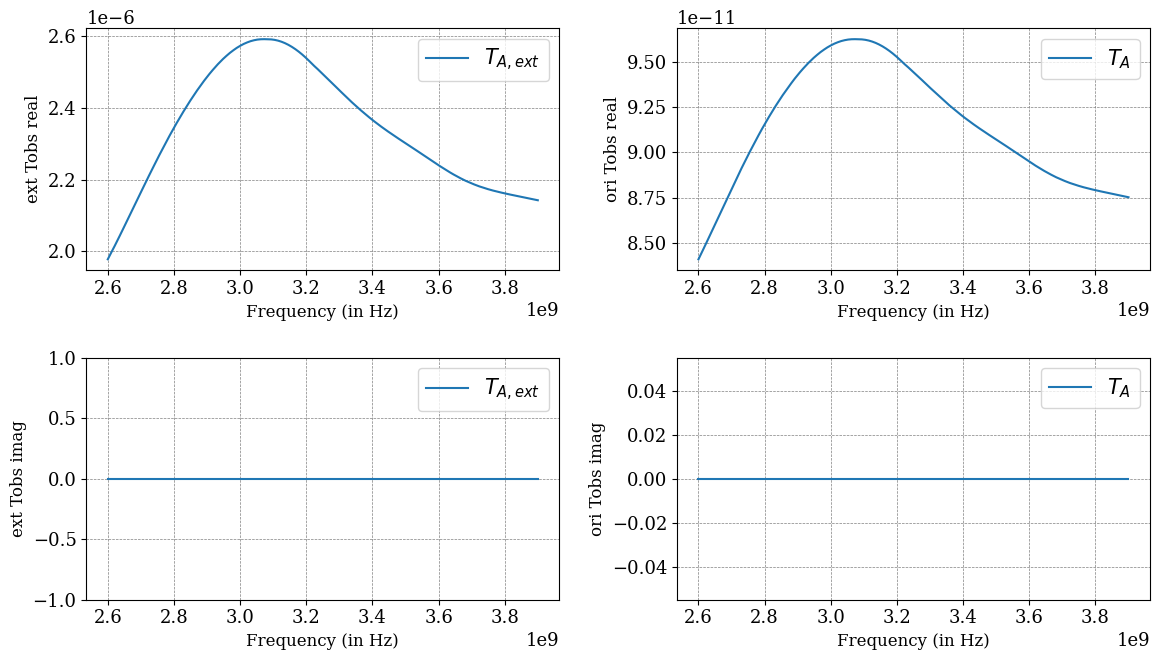

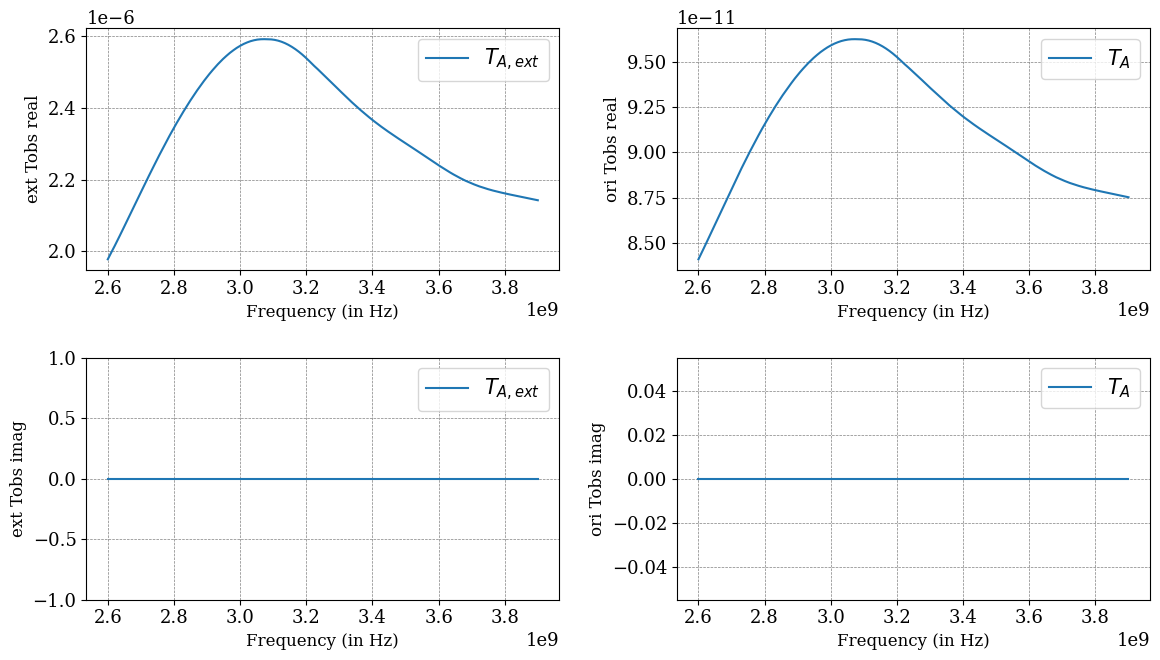

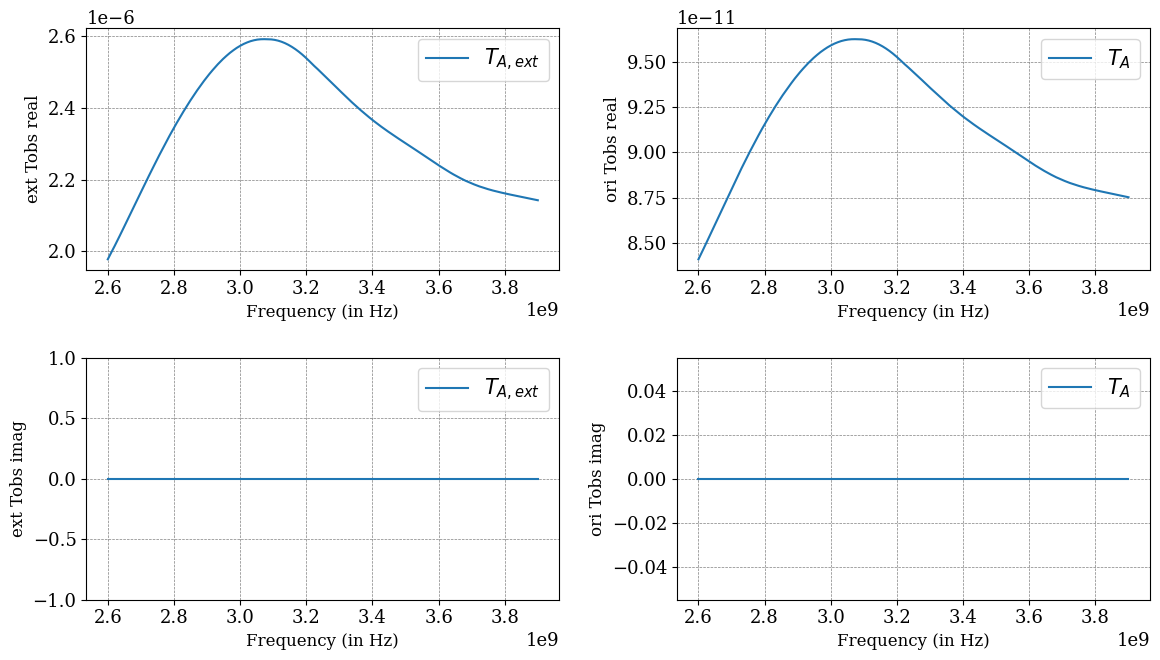

In [61]:
store_Ta = []
store_obs = []

for i in np.arange(0, 1,  0.1):
    pert_rrc_gen_i = perturbed_rrc_gen(apsera_freq, [0,i,-i,0],[0,0,0,0])

    _, temp, temp_obs = apsera_pipeline([V_nu, coldload_vsd, hotload_vsd, noise_300], apsera_freq, switch_ideal_on, switch_ideal_off, pert_rrc_gen_i, amp_ideal_15)
    
    store_Ta.append(np.array(temp))
    store_obs.append(np.array(temp_obs))

store_Ta = np.array(store_Ta)
store_obs = np.array(store_obs)

C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


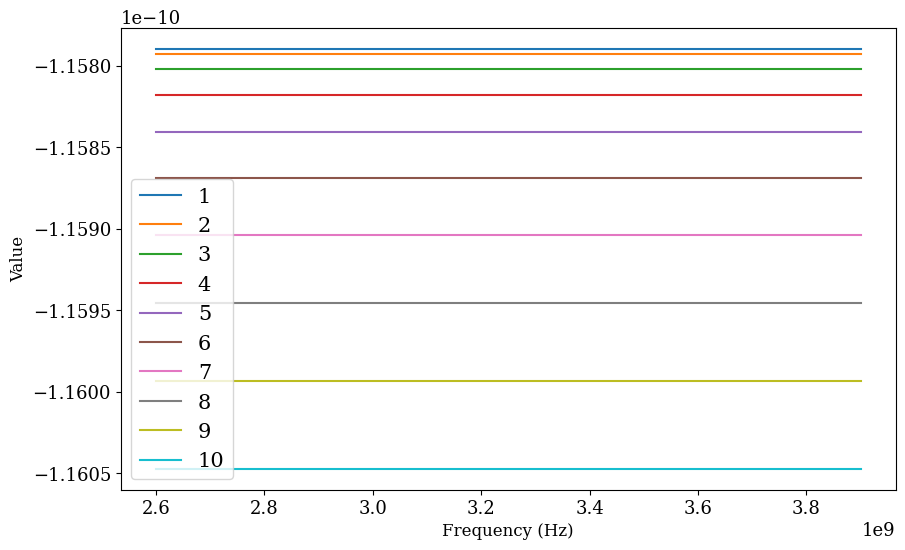

In [62]:
# Plot all arrays in store_Ta against apsera_freq
plt.figure(figsize=(10, 6))

for i, Ta in enumerate(store_obs):
    plt.plot(apsera_freq, Ta, label=f'{i+1}')  # Label each curve for identification

# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Value')
#plt.title('Plot of 11 Arrays against Frequency')

# Display legend
plt.legend()

# Show the plot
plt.show()